In [327]:
#Refer to https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
#Refer to: https://github.com/JanSchm/CapMarket/blob/master/bot_experiments/IBM_Transformer%2BTimeEmbedding.ipynb
#Train and then validate and test the model

In [328]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.9.1


## Hyperparameters

In [329]:
batch_size = 32
seq_len = 43 # seq_len=43 意思是用43天的数据预测第44天后的趋势
column_len = 6 #the number of column
predict_column = 5 #which column to be predict, from 0 to column_len-1
d_k = 256
d_v = 256
n_heads = 12 #12
ff_dim = 256
epochs = 20 #20
#
stock_id = '000333'
use_checkpoints_id = None #None or else. use other's pre-train model instead of itself(None)
train_from_scratch = False  # True: Train the model, False: Use the pre-train checkpoints
stock_price_path = 'stockData/' + stock_id + '.csv'
preictLen = 500 #Length of test date for predict, -1 means this args is ignore (10% pct is use for test);0 means predict the next date, 1 means predict today and next date... 

In [330]:
#Load data from DB to csv file
import psycopg2
import numpy
from psycopg2.extensions import register_adapter, AsIs
def addapt_numpy_float32(numpy_float32):
    return AsIs(numpy_float32)
def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)
def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)
register_adapter(numpy.float32, addapt_numpy_float32)
register_adapter(numpy.float64, addapt_numpy_float64)
register_adapter(numpy.int64, addapt_numpy_int64)


#Establishing the connection
conn = psycopg2.connect(
   database="easystogu", user='postgres', password='postgres', host='192.168.10.200', port= '5432'
)
#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

query = "select date,open,high,low,close,Volume from qian_fuquan_stockprice where stockid='" + stock_id + "' order by date"

outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query)

with open(stock_price_path, 'w') as f:
    cursor.copy_expert(outputquery, f)    

# Closing the connection
conn.close()

#Remove the first record, since it has big price change and will impact the AI
lines = []

with open(stock_price_path, 'r') as f:
    lines = f.readlines()

#Append the predict mock date price:     
latest_record = lines[len(lines)-1]
#Replace the latest record date to 9999-01-01 and append it to the last line of file
latest_record = '9999-01-01' + latest_record[10:]    
    
with open(stock_price_path, 'w') as f:
    f.writelines(lines[:1] + lines[2:] + list(latest_record)) 

# Moving Average

## Moving Average - Load data again, to apply rolling window

In [331]:
df = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=True)


# Apply moving average with a window of 10 days to all columns
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

# the max close price in next 19 days
df['Max_Close_Price_In_Next_N_Days'] = df['close'].rolling(20).max().shift(-19)
# the close price after 10 days
df['Close_Price_After_N_Days'] = df['close'].shift(-19)

# Close price is less than the max close price after 19 days
df['Max_Close_Diff'] = df['Max_Close_Price_In_Next_N_Days'] - df['close']
df['Close_Diff'] = df['Close_Price_After_N_Days'] - df['close']

# Result should be a predict number, 1 means the price trend is increase 
# (the max close and close within next 10 days is higher then current price)

df['Result'] = 0
df.loc[(df['Max_Close_Diff'] > 0) & (df['Close_Diff'] > 0), ['Result']] = 1

del df['Max_Close_Diff']
del df['Close_Diff']
del df['Close_Price_After_N_Days']
del df['Max_Close_Price_In_Next_N_Days']

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,date,open,high,low,close,volume,Result
9,2013-10-11,9.970,10.329,9.816,10.100,142945.7,1
10,2013-10-14,10.052,10.326,9.905,10.096,120740.9,1
11,2013-10-15,10.064,10.323,9.915,10.109,109978.4,1
12,2013-10-16,10.081,10.294,9.908,10.101,101731.7,1
13,2013-10-17,10.082,10.294,9.949,10.137,92603.6,1


## Moving Average - Plot daily closing prices and volume

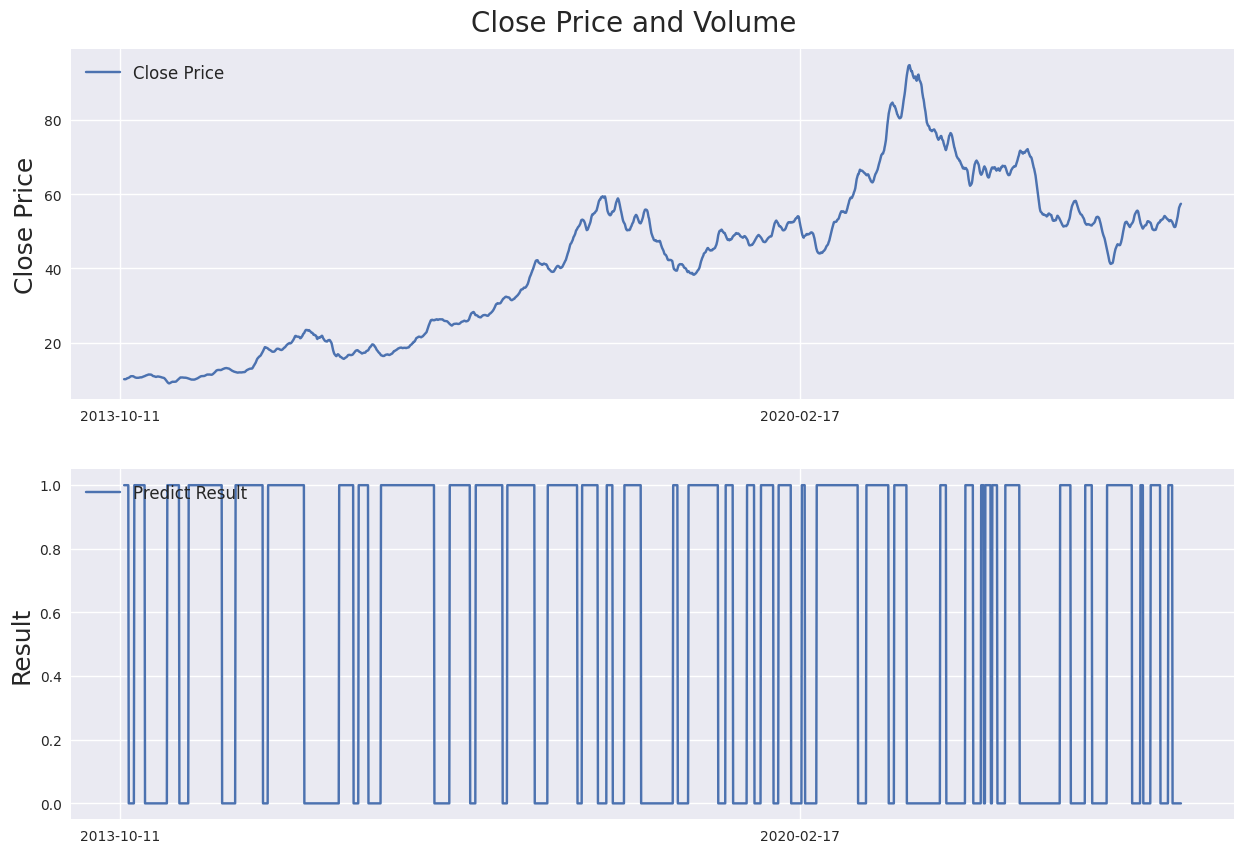

In [332]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Result'], label='Predict Result')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['date'].loc[::1464])
ax2.set_ylabel('Result', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
plt.show()

## Moving Average - Calculate normalized percentage change for all columns

In [333]:
'''Calculate percentage change'''

df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#Why min max is based on index < 20 pct? Why Not based on all?
min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
#Why min max is based on index < 20 pct? Why Not based on all?
min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize Result column'''

min_result = df[(df.index < last_20pct)]['Result'].min(axis=0)
max_result = df[(df.index < last_20pct)]['Result'].max(axis=0)

# Min-max normalize Result columns (0-1 range)
#It seams if result is either 0 or 1, then it does not need normalize
df['Result'] = (df['Result'] - min_result) / (max_result - min_result)
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]


if train_from_scratch == False and preictLen != -1:
    #if train_from_scratch is False
    #self.seq_len + self.preictLen + 1: the last +1 is for the prediction date
    df_test = df[-(seq_len + preictLen + 1):]
    df_test_with_date = df[-(seq_len + preictLen + 1):]                                    
else:
    #if train_from_scratch is True, then use the only last 10 pct for predict
    df_test = df[(df.index >= last_10pct)]
    df_test_with_date = df[(df.index >= last_10pct)]        

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
test_data_with_date = df_test_with_date.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (1820, 6)
Validation data shape: (228, 6)
Test data shape: (544, 6)


,open,high,low,close,volume,Result
10,0.738955,0.595781,0.753115,0.594005,0.069081,1.0
11,0.620737,0.595779,0.617640,0.622315,0.172061,1.0
12,0.629066,0.553429,0.588793,0.587358,0.194076,1.0
13,0.602332,0.600664,0.670242,0.660590,0.171143,1.0
14,0.657367,0.693768,0.663195,0.713455,0.341957,1.0


## Moving Average - Plot daily changes of close price and volume

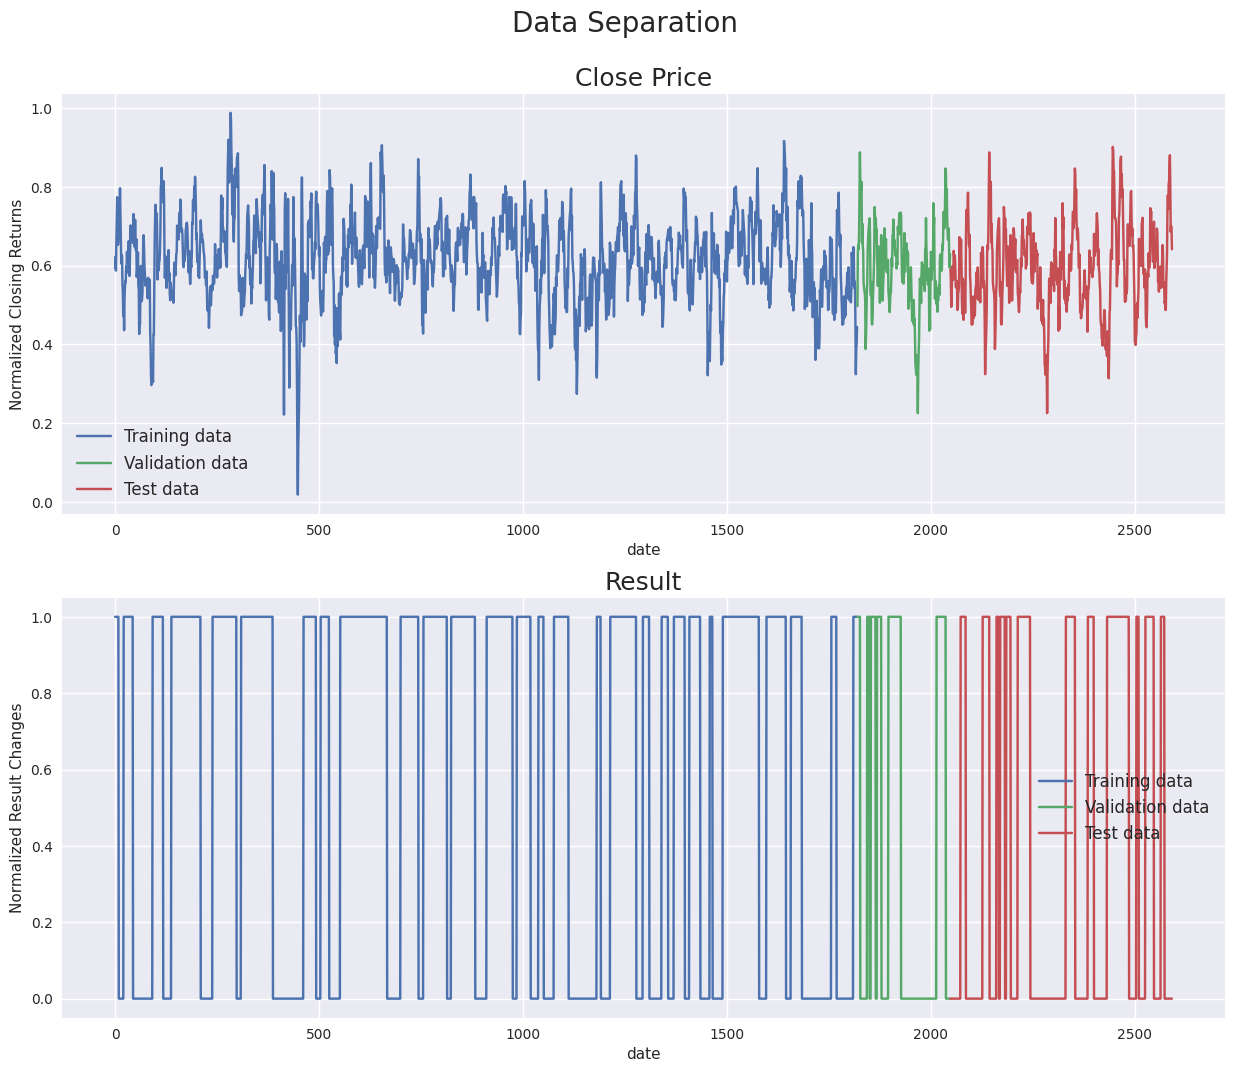

In [334]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Result'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Result'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Result'], label='Test data')
ax2.set_xlabel('date')
ax2.set_ylabel('Normalized Result Changes')
ax2.set_title("Result", fontsize=18)
ax2.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Create chunks of training, validation, and test data

In [335]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, predict_column][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, predict_column][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
X_test_with_data, X_test_last_43 = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    X_test_with_data.append(test_data_with_date[i-seq_len:i])
    y_test.append(test_data[:, predict_column][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test_with_data = np.array(X_test_with_data)
X_test_last_43 = X_test[-1:]
X_test_with_date_last_43 = X_test_with_data[-1:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
#print(X_test_with_date_last_43.shape)
#print(X_test_with_date_last_43)

(1777, 43, 6) (1777,)
(185, 43, 6) (185,)
(501, 43, 6) (501,)


## Moving Average - Model

In [336]:
from model.transformer import TransformerEncoder
from model.transformer import Time2Vector
from model.transformer import MultiAttention
from model.transformer import SingleAttention

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, column_len))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  #out = Dense(1, activation='linear')(x)
  out = Dense(1, activation='sigmoid')(x) #predict 1 or 0

  model = Model(inputs=in_seq, outputs=out)
  #model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])#linear use mse
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mape'])#sigmoid use binary_crossentropy
  return model


model = create_model()
model.summary()

ckp = './checkpoints/Transformer+TimeEmbedding_' + str(seq_len) + '_' + stock_id + '.hdf5'
callback = tf.keras.callbacks.ModelCheckpoint(ckp, 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

if train_from_scratch:
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
else:
    if use_checkpoints_id != None:
        ckp = './checkpoints/Transformer+TimeEmbedding_' + str(seq_len) + '_' + use_checkpoints_id + '.hdf5'
        
    model = tf.keras.models.load_model(ckp,
                                       custom_objects={'Time2Vector': Time2Vector, 
                                                       'SingleAttention': SingleAttention,
                                                       'MultiAttention': MultiAttention,
                                                       'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 43, 6)]      0           []                               
                                                                                                  
 time2_vector_38 (Time2Vector)  (None, 43, 2)        172         ['input_23[0][0]']               
                                                                                                  
 concatenate_22 (Concatenate)   (None, 43, 8)        0           ['input_23[0][0]',               
                                                                  'time2_vector_38[0][0]']        
                                                                                                  
 transformer_encoder_114 (Trans  (None, 43, 8)       111920      ['concatenate_22[0][0]',  

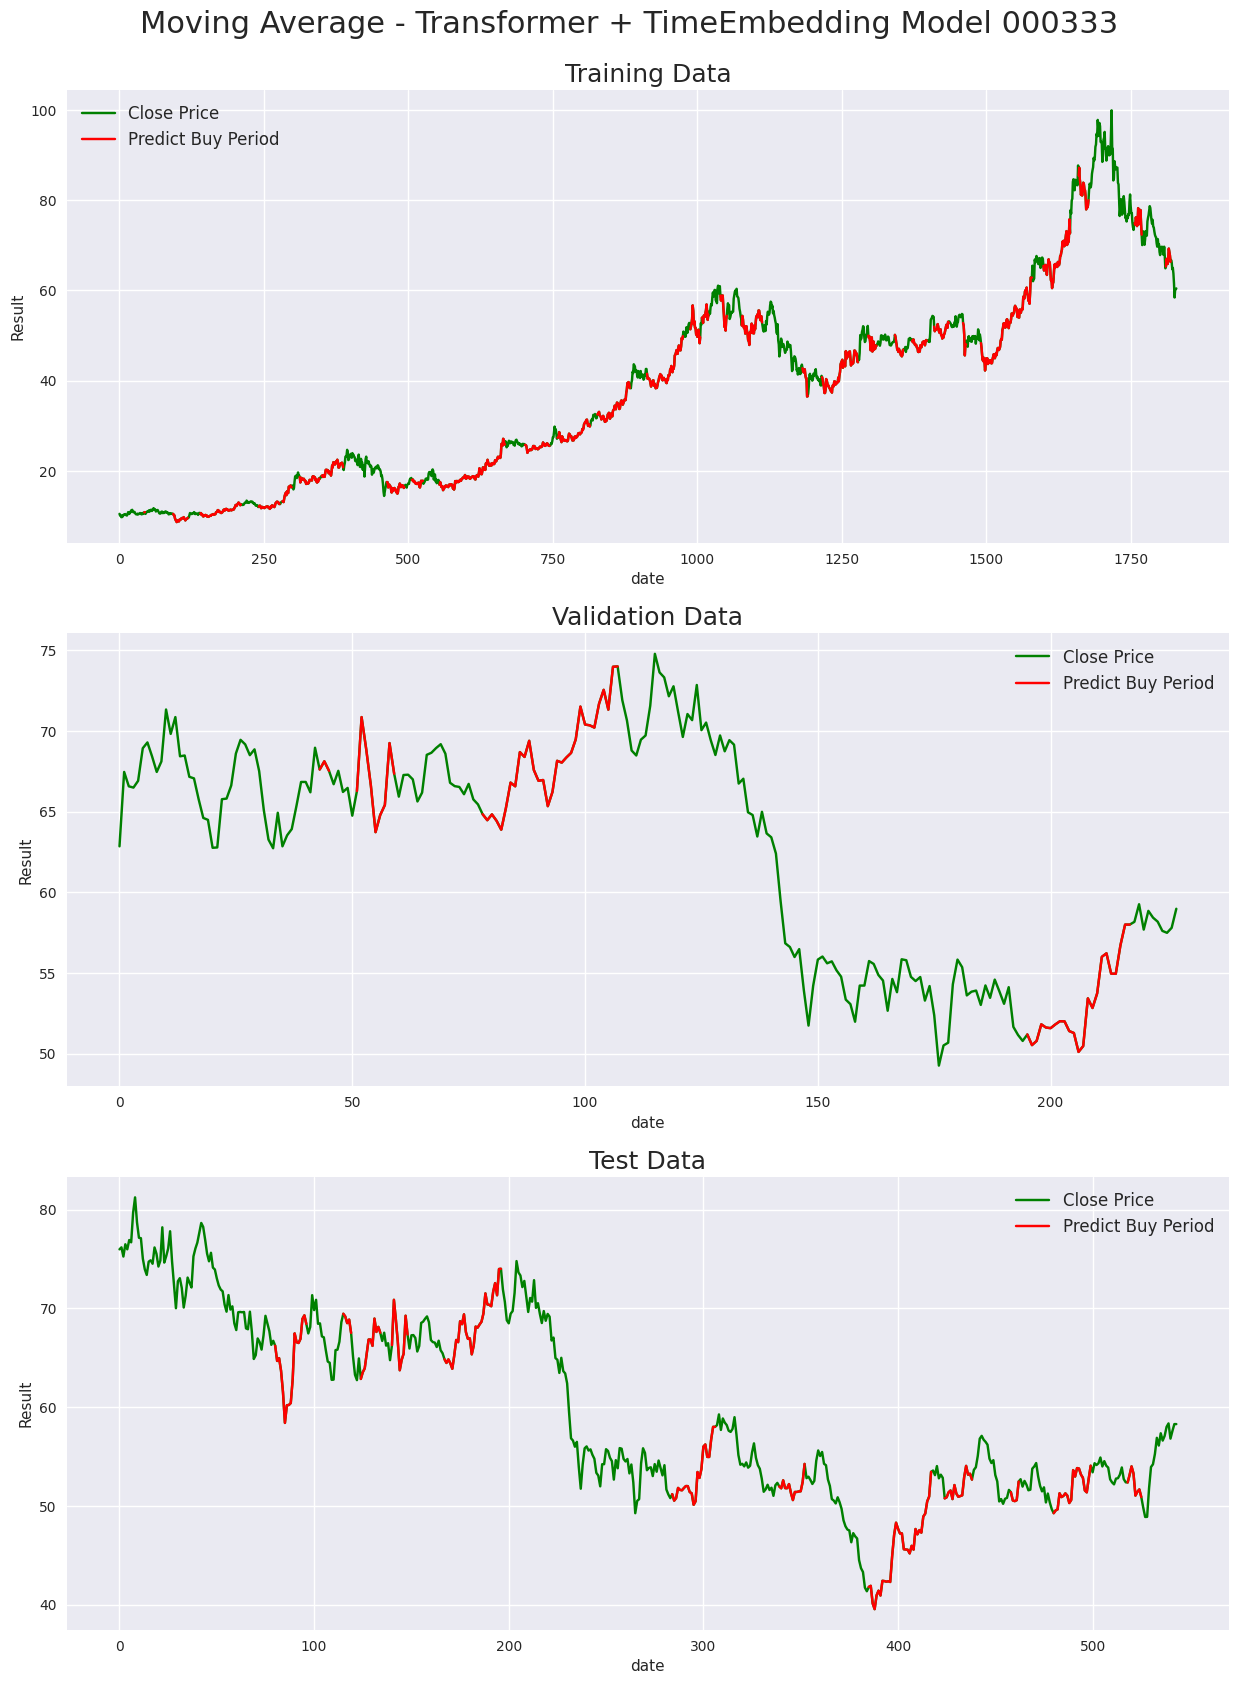

In [337]:
###############################################################################
'''Display results'''

df2 = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
df2.sort_values('date', inplace=True)
df2_close = df2['close'].values

df2_test_close_price   = df2_close[-len(test_data):]
df2_val_close_price    = df2[(df2.index >= last_20pct) & (df2.index < last_10pct)]['close'].values
df2_train_close_price  = df2[(df2.index < last_20pct)]['close'].values
####

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model " + stock_id, fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
#ax11.plot(train_data[:, 3], label='Result')
ax11.plot(df2_train_close_price, label='Close Price', color='g')
#ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Result')

df2_train_close_price_4_show = df2_train_close_price[-(len(df2_train_close_price)-seq_len):]
states_buy = []
index = 0
for pred in train_pred:
    if pred >= 0.75:
        states_buy.append(df2_train_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    
        
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')

ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('date')
ax11.set_ylabel('Result')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
#ax21.plot(val_data[:, 3], label='Result')
ax21.plot(df2_val_close_price, label='Close Price', color='g')
#ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Result')

df2_val_close_price_4_show = df2_val_close_price[-(len(df2_val_close_price)-seq_len):]
states_buy = []
index = 0
for pred in val_pred:
    if pred >= 0.75:
        states_buy.append(df2_val_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    
        
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')


ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('date')
ax21.set_ylabel('Result')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
#ax31.plot(test_data[:, 3], label='Result')
ax31.plot(df2_test_close_price, label='Close Price', color='g')
#ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Result')

df2_test_close_price_4_show = df2_test_close_price[-(len(df2_test_close_price)-seq_len):]
states_buy = []
index = 0
for pred in test_pred:
    if pred >= 0.75:
        states_buy.append(df2_test_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    
        
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')

#
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('date')
ax31.set_ylabel('Result')
ax31.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Model metrics

In [338]:
'''Display model metrics'''
if train_from_scratch:
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
    st.set_y(0.92)

    #Plot model loss
    ax1 = fig.add_subplot(311)
    ax1.plot(history.history['loss'], label='Training loss (MSE)')
    ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
    ax1.set_title("Model loss", fontsize=18)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc="best", fontsize=12)

    #Plot MAE
    ax2 = fig.add_subplot(312)
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean average error (MAE)')
    ax2.legend(loc="best", fontsize=12)

    #Plot MAPE
    ax3 = fig.add_subplot(313)
    ax3.plot(history.history['mape'], label='Training MAPE')
    ax3.plot(history.history['val_mape'], label='Validation MAPE')
    ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Mean average percentage error (MAPE)')
    ax3.legend(loc="best", fontsize=12)
    plt.show()

In [339]:
#5. Analysis for the result (in progress)

#Because the prediction is calculated by Moving average and then normalziation, so we are trying to return the difference to the real world. \

#Here, we calculate the difference between real case and prediction, and compared with the real result.


In [340]:
print(X_test.shape, y_test.shape)
test_pred = model.predict(X_test)

print('len of test_pred:', len(test_pred))
df_test_with_date=df_test_with_date[-(len(df_test_with_date)-seq_len):]
print('len of df_test_with_date:', len(df_test_with_date))

print('last 60 of test_pred:',test_pred[-60:])
print('last 60 of df_test_with_date:',df_test_with_date['date'][-60:])

#for pred in test_pred:
#    print(pred)
#for date in df_test_with_date['date'].values:
#    print(date)

(501, 43, 6) (501,)
16/16 [==============================] - 1s 75ms/step
len of test_pred: 501
len of df_test_with_date: 501
last 60 of test_pred: [[0.9855781 ]
 [0.9807302 ]
 [0.9795156 ]
 [0.97723275]
 [0.97061116]
 [0.95703894]
 [0.94635916]
 [0.9219707 ]
 [0.9068383 ]
 [0.8721097 ]
 [0.8706694 ]
 [0.87808686]
 [0.87576526]
 [0.9113043 ]
 [0.9013878 ]
 [0.8623139 ]
 [0.07735291]
 [0.01297933]
 [0.00652968]
 [0.00418973]
 [0.00526456]
 [0.00875284]
 [0.0090226 ]
 [0.00997761]
 [0.00924691]
 [0.00931533]
 [0.00924342]
 [0.01019078]
 [0.0130422 ]
 [0.01394065]
 [0.01503057]
 [0.01569297]
 [0.01702769]
 [0.47720614]
 [0.8630149 ]
 [0.9349033 ]
 [0.9672239 ]
 [0.96581507]
 [0.96036404]
 [0.9669008 ]
 [0.97635454]
 [0.97725177]
 [0.29110447]
 [0.04631791]
 [0.0193706 ]
 [0.00995267]
 [0.00777831]
 [0.00862474]
 [0.00914091]
 [0.01060321]
 [0.00870269]
 [0.00958603]
 [0.01043692]
 [0.01077245]
 [0.01607095]
 [0.01756657]
 [0.01855839]
 [0.02320195]
 [0.03070303]
 [0.03852802]]
last 60 of 

In [341]:
#Save AI predict to DB
import psycopg2
import numpy
from psycopg2.extensions import register_adapter, AsIs
def addapt_numpy_float32(numpy_float32):
    return AsIs(numpy_float32)
def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)
def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)
register_adapter(numpy.float32, addapt_numpy_float32)
register_adapter(numpy.float64, addapt_numpy_float64)
register_adapter(numpy.int64, addapt_numpy_int64)


#Establishing the connection
conn = psycopg2.connect(
   database="easystogu", user='postgres', password='postgres', host='192.168.10.200', port= '5432'
)
#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#First delete then insert
index=0
for date in df_test_with_date['date'].values:
    result=test_pred[index][0]
    cursor.execute("delete from AI_TREND_PREDICTION where stockid=%s and date=%s", (stock_id,date))
    cursor.execute("insert into AI_TREND_PREDICTION (stockid,date,result) values(%s, %s, %s)", (stock_id, date, result))
    index+=1

# Commit your changes in the database
conn.commit()

# Closing the connection
conn.close()